## Data loading

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

import regex as re
from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_dependency_ecosystem"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
ftc_df = df[df[ftc_key]]
print(f'{len(df)=}')
print(f'{len(ftc_df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields
                          and field != ftc_key)]

df[independent_fields].describe()

class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(class_imbalance)

Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'ln(1 + SharedExperiencePullReq

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),...,ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality)
count,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,...,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000,222919.000000
mean,0.715574,0.815452,0.542513,0.327287,0.368079,0.115983,0.313192,0.245195,0.218851,0.078235,...,0.031053,0.060385,0.188145,0.302456,0.063138,0.108372,0.052574,0.096633,0.135202,0.115875
std,0.408035,0.281996,0.473802,0.448171,0.205082,0.067751,0.173881,0.182839,0.199958,0.166624,...,0.102845,0.135882,0.147686,0.193613,0.113169,0.160163,0.113854,0.172460,0.105476,0.104472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.800000,0.000000,0.000000,0.197273,0.075257,0.192585,0.093156,0.000000,0.000000,...,0.000000,0.000000,0.089382,0.155067,0.000000,0.000000,0.000000,0.000000,0.058085,0.037414
50%,0.952381,0.928571,0.833333,0.000000,0.363294,0.075257,0.324045,0.240804,0.182542,0.000000,...,0.000000,0.000000,0.178763,0.310134,0.000000,0.000000,0.000000,0.000000,0.112602,0.089484
75%,1.000000,1.000000,1.000000,0.918919,0.523295,0.119279,0.441411,0.388453,0.373067,0.000000,...,0.000000,0.000000,0.296920,0.450264,0.117002,0.202881,0.000000,0.138630,0.189074,0.165979
max,1.000000,1.000000,1.000000,1.000000,0.980358,0.898782,0.997359,0.744192,0.958786,1.000000,...,1.000000,0.793212,0.854348,0.886728,1.000000,1.000000,1.000000,1.000000,0.870413,0.865460


## Model Creation

### Re-usable Functions

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score


def calculate_metrics(predicted_labels, true_labels, sample_weights=None):
    return {
        "accuracy": accuracy_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "precision": precision_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "recall": recall_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "f1": f1_score(true_labels, predicted_labels, sample_weight=sample_weights)
    }


def create_model(
    train_predictors: pd.DataFrame,
    train_labels: pd.Series,
    test_predictors: pd.DataFrame,
    test_labels: pd.Series,
    random_state: int | None = None,
):
    # Model creation and predictions.
    if random_state is None:
        random_state = seed_counter.get_next()
    print(f'{random_state=}')
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=random_state)

    rf.fit(train_predictors, train_labels)

    predictions = rf.predict(test_predictors)
    predictions = [pred >= 0.5 for pred in predictions]

    # F1 scores.
    conf = confusion_matrix(test_labels, predictions)

    metrics = calculate_metrics(predictions, test_labels)

    print(f'{metrics=}\n')

    # Other metrics.
    print(f'Confusion matrix:\n{conf}\n')
    print("Classification report:")
    print(classification_report(test_labels, predictions))

    return rf, metrics


In [6]:
from typing import Iterator
import regex as re
from sklearn.model_selection import KFold
from python_proj.utils.mt_utils import parallelize_tasks


def kfold_rf_evaluation(
    _df: pd.DataFrame,
    predictor_fields: Iterator[str],
    k: int = 5
):
    random_state = seed_counter.get_next()

    def create_model_for_fold(task, *args, **kwargs):
        train_idx, test_idx = task
        train = _df.loc[train_idx, :]
        test = _df.loc[test_idx, :]
        train_predictors = train[predictor_fields]
        train_labels = train[pr_merged_key]
        test_predictors = test[predictor_fields]
        test_labels = test[pr_merged_key]
        _, rf_metrics = create_model(
            train_predictors,
            train_labels,
            test_predictors,
            test_labels,
            random_state
        )
        return rf_metrics

    kf = KFold(
        n_splits=k,
        shuffle=True,
        random_state=seed_counter.get_next()
    )
    tasks = kf.split(_df)
    models_and_f1s = parallelize_tasks(
        tasks,
        create_model_for_fold,
        thread_count=min(k, 8),
        return_results=True,
        print_lifetime_events=False
    )

    f1_scores = [entry['f1'] for entry in models_and_f1s]
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)

    return f1_scores, f1_mean, f1_std


### Full Model

In [7]:
f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields)

print("\nPerformance metrics full model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')


SimpleConsumer-0 started.
SimpleConsumer-1 started.
SimpleConsumer-2 started.
SimpleConsumer-3 started.
SimpleConsumer-4 started.
random_state=44
random_state=44random_state=44

random_state=44
random_state=44
metrics={'accuracy': 0.944083079131527, 'precision': 0.9521399547434244, 'recall': 0.9867365979121488, 'f1': 0.9691296110553883}

Confusion matrix:
[[ 2959  1967]
 [  526 39132]]

Classification report:
              precision    recall  f1-score   support

       False       0.85      0.60      0.70      4926
        True       0.95      0.99      0.97     39658

    accuracy                           0.94     44584
   macro avg       0.90      0.79      0.84     44584
weighted avg       0.94      0.94      0.94     44584

SimpleConsumer-3: Received termination task.
SimpleConsumer-3: Stopped.
metrics={'accuracy': 0.944307374842993, 'precision': 0.9520797859401605, 'recall': 0.9870627695256349, 'f1': 0.969255723536768}

Confusion matrix:
[[ 2961  1970]
 [  513 39140]]

Classific

### Control + Intra-project Model

In [8]:
# Creates control model + Intra fields.
contr_with_intra = [field for field in independent_fields
                    if re.match(r'.*(Control|Intra).*',field)]
contr_with_intra = list(contr_with_intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, contr_with_intra)

print("\nPerformance metrics control + intra model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
SimpleConsumer-0 started.
SimpleConsumer-1 started.
SimpleConsumer-2 started.
SimpleConsumer-3 started.
SimpleConsumer-4 started.
random_state=45random_state=45

random_state=45
random_state=45random_state=45

metrics={'accuracy': 0.9366364615108559, 'precision': 0.9507618441036696, 'recall': 0.9794332147273324, 'f1': 0.964884585265199}

Confusion matrix:
[[ 2947  2010]
 [  815 38812]]

Classification report:
              preci

### Collaboration and Ecosystem Model

In [9]:
# Creates measured information model.
non_control_fields_wo_intra = [field for field in independent_fields
                               if not re.match(r'.*(Intra|Control).*', field)]
non_control_fields_wo_intra = list(non_control_fields_wo_intra)
print(non_control_fields_wo_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, non_control_fields_wo_intra)

print("\nPerformance metrics non-control model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)', 'ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)', 'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)', 'ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)', 'ln(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystem

## Feature Explanation

### Partial Dependence Plots

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt


def create_partial_dependence_plots(
        rf_model: RandomForestRegressor,
        used_predictors: pd.DataFrame,
        model_name: str = ""):

    # Collective partial dependence plot.
    PartialDependenceDisplay.from_estimator(
        rf_model, used_predictors, used_predictors.columns)

    fig = plt.gcf()
    axs = fig.axes

    lines = []
    for ax in axs:
        __lines = list([(line.get_xdata(), line.get_ydata())
                        for line in ax.lines])
        lines.extend(__lines)

    for (x, y), label in zip(lines, used_predictors.columns):
        plt.clf()
        plt.plot(x, y, linestyle='-', color='#e69d00')
        plt.xlabel(label)
        plt.ylabel('Partial Dependence')
        plt.tight_layout()
        output_path = f"{figure_base_path}/partial-dependence/{model_name}/{label}.png"
        safe_save_fig(output_path)


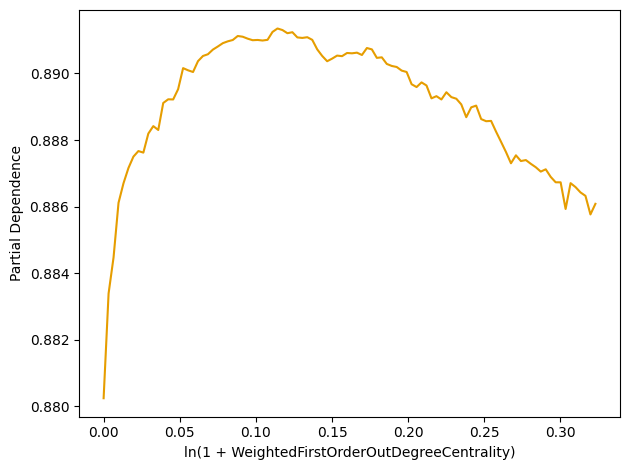

In [ ]:
full_rf_model, _ = create_model(
    train_predictors, train_dependent,
    test_predictors, test_dependent
)

create_partial_dependence_plots(
    full_rf_model,
    test_predictors,
    model_name="full_model"
)


### Mean decrease in Accuracy

In [ ]:
feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel('Feature Index')
plt.ylabel('Mean Decrease Accuracy')
plt.title('Mean Decrease Accuracy of Features')
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

for field, importance in zip(ordererd_columns, sorted_importances):
    print(f'{field}: {importance:.04f}')
